# Regression: synthetic dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # for regression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import sklearn
import copy

import shap

from pred_diff import preddiff, shapley
from pred_diff.imputers import imputer_base, tabular_imputers, general_imputers
import pred_diff.tools.plot as c_plt
from pred_diff.datasets.datasets_regression import SyntheticDataset
from pred_diff.tools import init_plt

Select plotting style

In [2]:
# paper style
init_plt.update_rcParams(fig_width_pt=234.88*2)

# default
plt.style.use('default')


### Set-up experiment
1. Specify mean and covariance for dataset


In [3]:
# create synthetic dataset
c = 0.
cov = [[1., c, c, c],
       [c, 1., c, c],
       [c, c, 1., c],
       [c, c, c, 1.]]
mean = np.array([0, 0, 0, 0])

2. Create custom target functions

In [4]:
def f(x: np.ndarray) -> np.ndarray:
    x0 = x[:, 0]; x1 = x[:, 1]; x2 = x[:, 2]; x3 = x[:, 3]

    y_additive = x0 ** 2 + 3 * x1 + np.sin(np.pi * x2) - 0.5 * x3 ** 3
    y_interaction = 2 * np.sign(x0) * np.abs(x1)

    return y_additive + y_interaction

dataset = SyntheticDataset(function=f, mean=mean, cov=cov)

class AnalyticModel:
    def __init__(self, function):
        self.predict = function

reg_analytic = AnalyticModel(function=f)


3. Select model

In [5]:
model_selection = 'RandomForest'
model_selection = 'AnalyticModel'
# model_selection = 'FullyConnectedNetwork'
# model_selection = 'GaussianProcess'

4. Train model

In [6]:
x_df, y_df = dataset.load_pd()
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_df, y_df, test_size=0.1)
if model_selection == 'RandomForest':
    reg = RandomForestRegressor(n_estimators=100)
elif model_selection == 'FullyConnectedNetwork':
    reg = MLPRegressor([int(x_df.shape[0])])
elif model_selection == 'GaussianProcess':
    reg = GaussianProcessRegressor(1.0 * RBF() + WhiteKernel())
elif model_selection == 'AnalyticModel':
    reg = AnalyticModel(function=f)
else:
    assert False, f'Please enter a valid model_selection = {model_selection}'

if model_selection != 'AnalyticModel':
    reg.fit(x_train, y_train)
    print(f"train data:     "
          f"score = {reg.score(x_train, y_train):.3f}\n"
          f"test data:      "
          f"score = {reg.score(x_test, y_test):.3f}")

## *PredDiff*

In [7]:
n_imputations = 200
error_bars = False

imputer = tabular_imputers.GaussianProcessImputer(train_data=x_train)


explainer = preddiff.PredDiff(model=reg, train_data=copy.deepcopy(x_train.to_numpy()),
                              n_imputations=n_imputations, imputer=imputer, fast_evaluation=(error_bars==False),
                              n_group=100, unified_integral=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### *PredDiff* relevances

Relevance:   0%|          | 0/4 [00:00<?, ?it/s]

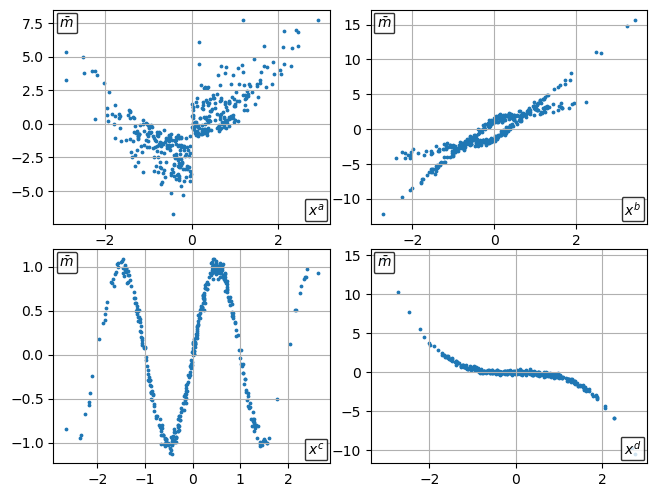

In [8]:
c_plt.scatter_m_plots(explainer=explainer, df_test=x_test, n_imputations=n_imputations, error_bars=error_bars)

### *PredDiff* shielded effects

Calculate PredDiff interactions.
Evaluating m-values for every element in list_interaction_masks...


Interaction:   0%|          | 0/1 [00:00<?, ?it/s]

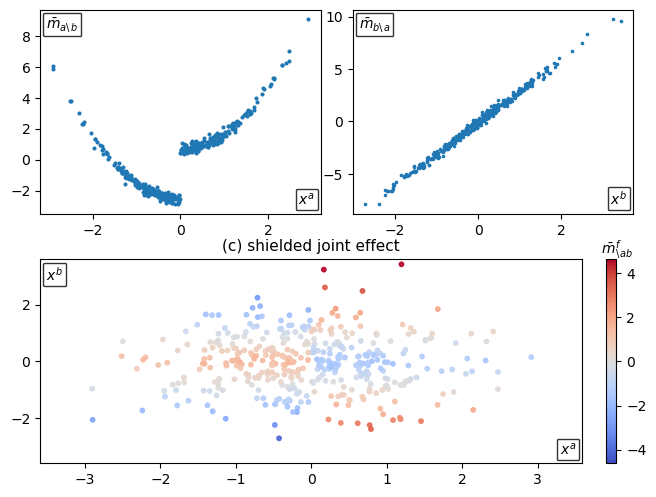

In [9]:
c_plt.shielded_effects(explainer=explainer, data_test=x_test.to_numpy(),
                       x=x_test['0'], y=x_test['1'],
                       title='PredDiff - 0 vs. 1', axis_symmetric=True, error_bars=error_bars)

## Shapley values
Using a custom implementation derived from our *PredDiff* explainer class. This allows to use identical conditional distributions for imputation. 

In [10]:
features = np.arange(4, dtype=np.int)
explainer = shapley.ShapleyExplainer(model=reg, train_data=copy.deepcopy(x_train.to_numpy()), n_coalitions=n_imputations,
                                     n_imputations=1, imputer=imputer, n_group=200)

list_masks = []
for i in range(len(features)):
    mask = np.zeros(features.shape, dtype=np.bool)
    mask[i] = True
    list_masks.append(mask)
shapley_list = explainer.shapley_values(data_test=x_test.to_numpy(), list_masks=list_masks,
                                        base_feature_mask=features)
shapley_values = np.array([m['mean'] for m in shapley_list])
shapley_c = pd.DataFrame(shapley_values.T, columns=x_test.keys())

shapley values:   0%|          | 0/4 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values:  25%|██▌       | 1/4 [00:05<00:17,  5.96s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values:  50%|█████     | 2/4 [00:12<00:12,  6.09s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values:  75%|███████▌  | 3/4 [00:18<00:06,  6.08s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values: 100%|██████████| 4/4 [00:24<00:00,  6.12s/it]


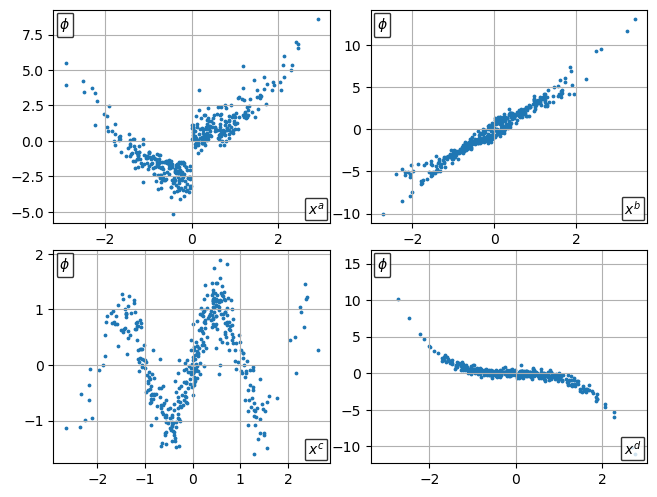

In [11]:
c_plt._scatter(c=shapley_c, x_df=x_test, method='custom shapley')

## Shapley interaction index

In [12]:
shap_interaction = explainer.shap_interaction_matrix(data_test=x_test.to_numpy(), base_feature_mask=features)

shapley values:   0%|          | 0/4 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values:  25%|██▌       | 1/4 [00:05<00:16,  5.53s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values:  50%|█████     | 2/4 [00:11<00:11,  5.70s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley values:  75%|███████▌  | 3/4 [00:17<00:05,  5.70s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index:   0%|          | 0/6 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index:  17%|█▋        | 1/6 [00:11<00:57, 11.48s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index:  33%|███▎      | 2/6 [00:22<00:44, 11.21s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index:  50%|█████     | 3/6 [00:33<00:33, 11.19s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index:  67%|██████▋   | 4/6 [00:44<00:22, 11.18s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index:  83%|████████▎ | 5/6 [00:55<00:11, 11.14s/it]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

Relevance:   0%|          | 0/200 [00:00<?, ?it/s]

shapley interaction index: 100%|██████████| 6/6 [01:06<00:00, 11.03s/it]


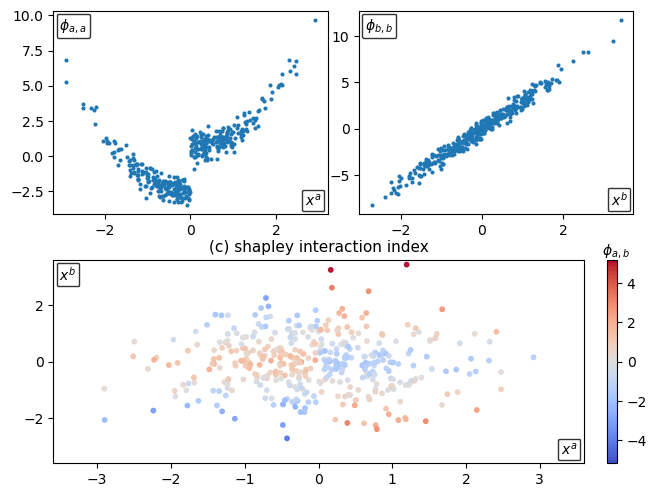

In [13]:
c_plt.shap_interaction(shap_interaction_values=shap_interaction, x=x_test['0'], y=x_test['1'],
                       title='custom shapley', axis_symmetric=True)